In [31]:
# import all modules
import numpy as np
import PIL.Image as Image
import libtiff
from matplotlib import pyplot as plt
import matplotlib
from skimage import io
from PRIS import SingleObs
import copy
import drawnow

# Construct obseration operator

In [32]:
# construct observation operator.
 # load psf matrix
dpath = './test_data/psf.tif';
psf = io.imread(dpath)


# Load observation

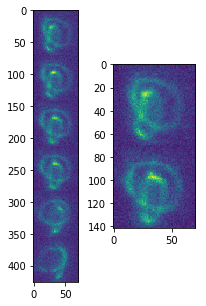

In [33]:
# load observation
data_path = './test_data';
f = 'obsStack.tif';
fov = io.imread(data_path + '/' + f)
fov.shape
plt.figure(figsize=(5,5));
plt.subplot(131)
plt.imshow(fov[[1,3,5,6,10,15],:,:].reshape(6*fov.shape[1],fov.shape[2]))
blur1 = fov[1,:,:];
blur2 = fov[5,:,:];

blur = np.concatenate([blur1, blur2]).reshape(2*71,71);
plt.subplot(132)
plt.imshow(blur)

# Decide candidates

In [34]:
# decide candidates 
range_ind0 = np.arange(-30,25)
range_ind1 = np.arange(12,62,2)
range_ind2 = np.arange(10,60,2)
candidate_locs = list()
for i0 in range_ind0:
    for i1 in range_ind1:
        for i2 in range_ind2:
            candidate_locs.append([i0,i1,i2])

# Construct sensing matrix

In [35]:
# construct sensing matrix
    # dependencies: candidates, observation operator.
    # yield: sensing matrix
    # method: loop over all candidates and record the corresponding observations.
a = SingleObs()
a.psf = np.copy(psf)
a.psfz0 = 106
a.debug = False
a.imsize = blur1.shape
a.edge_padding = True
A = np.ndarray([blur.shape[0]*blur.shape[1], len(candidate_locs)+1])
A.shape
for count, loc in enumerate(candidate_locs):
#for count, loc in enumerate([[0,10,10],[10,10,10]]):
    
    loc1 = np.copy(loc); loc1[0] = np.copy(loc[0])-8
    loc2 = np.copy(loc); loc2[0] = np.copy(loc[0])+8
    a.location = loc1
    a.single_obs()
    a1 = a.obs.ravel()
    
    a.location = loc2
    a.single_obs()
    a2 = a.obs.ravel()
    
    A[:,count] = np.concatenate([a1.ravel(),a2.ravel()]).ravel()
A[:,len(candidate_locs)] = 1

# Define LinBreg

In [57]:
class LinBreg:
    # Authors: Xiyu Yi, Xingjia Wang @ UCLA, 2019.
    # PI: Shimon Weiss, Department of Chemistry and Biochemistry, UCLA.
    import time
    def __init__(self, A, x, b):
        # solve for x from Ax = b.
        self.A = A # sensing matrix.
        self.x = x # coefficient vector for the pool of candidates.
        self.b = b # observation vector.
        self.mu = np.mean(self.b.ravel())  # shrinkage threshold.
        self.er = np.zeros(self.b.shape)
        self.erpj = np.zeros(self.x.shape)
        self.cumerr = np.zeros(self.x.shape)
        self.recb = np.zeros(self.b.shape)
        self.flag_stop = False # flag to stop optimization iteration.
        self.maxit = 2 # maximum iteration steps.
        self.debug_it_int = 1
        self.flag_positivity = True
        self.it_check_rem = 1
        self.iterations = list()
        self.hist_res = list()
        self.hist_resDrop = list()
        
        self.bg = list()
        self.alpha = 1
        self.debug = False
        self.deep_debug = False
        self.kicking_flag = False
        self.kicking_ints = 10 # number of iterations between kicking evaluation.
        self.kicking_reference = self.x
        self.kicking_option = False
        self.kicking_thres = 1e-10
        self.kicking_refnorm = np.max(self.x)
        self.hist_kicking_refnorm = list()
        self.hist_kicking_eval_counts = list()
        self.stepsize = np.ones(self.x.shape) # stepsize.     

    def getready(self):
        if self.debug is True:
            import os
            # define the name of the directory to be created.
            path = "../../PyPRIS_Scratch/debug_output"
            try:  
                os.mkdir(path)
            except OSError:  
                print ("Creation of the directory %s failed" % path)
            else:  
                print ("Successfully created the directory %s " % path)
                

    def shrink(self,sk):
        sk[np.where((sk >= -self.mu) * (sk <= self.mu))] = 0
        sk[np.where(sk > self.mu)] -= self.mu
        sk[np.where(sk < -self.mu)] += self.mu
        return sk
    
    def kicking_evaluation(self):
        self.kicking_refnorm = np.linalg.norm(self.x-self.kicking_reference)
        if self.kicking_refnorm < self.kicking_thres:
            # flip the kicking flag to "True" with positive evaluation
            self.kicking_flag = True
        else:
            # flip the kicking flag to "False" with negative evaluation.
            self.kicking_flag = False
            
        self.hist_kicking_refnorm.append(self.kicking_refnorm)
        self.hist_kicking_eval_counts.append([it_count, self.kicking_flag])

    def kicking_go(self):
        # execute kicking
        # kicking execution only modifies the domains of the step size 
        # and split domains in a binary way.
        i0 = np.where(self.x == 0) # zero entries on x [x entries where there kicking is in demand]
        i1 = np.where(self.x != 0) # none zero entries in x. [x entries where there is a value, no need for kicking]
        si = (self.mu *np.sign(self.erpj[i0]) - self.x[i0]) / self.erpj[i0] # stepsie for entries that needs kicking
        self.stepsize[i0] = np.min(si)  
        self.stepsize[i1] = 1

        # reset kicking_flag to False and wait for the flip 
        # from the next positive kicking evaluation
        self.kicking_flag = False 

        # update kicking_reference for follow-up kicking evaluation
        self.kicking_reference = copy.deepcopy(self.x)

    def go(self):
        t1 = time.time()
        it_count = 0
        self.hist_res.append(0)
        self.hist_resDrop.append(0)
        self.iterations.append(it_count)
        self.bg.append(self.x[self.x.size-1]) 
        # main linearized bregman iteration with kicking option.
        while self.flag_stop is False:
            # incrementation of the iteration number.
            it_count += 1
            
            # calculate distance (error)
            self.recb = np.dot(self.A, self.x)
            self.er = self.b - self.recb 
            if self.deep_debug is True: self.debug_output(it_count, appstr = '_a_er_updated')
            
            # perform back projection of the error ('adding the errors back').
            self.erpj = np.dot(self.er, self.A)  
            if self.deep_debug is True: self.debug_output(it_count, appstr = '_b_erpj_updated')
            
            # check if kicking is needed 
            #
            # "Kicking" rescales the backprojected error (self.erpj) with two different stepsizes
            # we'll have stepsize > 1 for kicking area, and stepsize = 1 for non-kicking area. 
            # kicking boosts the tip of the cumulated backprojected errors towards the shrinkage 
            # threshold.
            # In this implementation, the effect of kicking is realized throught a modified. 
            # distribution of stepsizes (self.stepsize). 
            if np.remainder(it_count, self.kicking_ints) == 0:
                self.kicking_evaluation()
                # kick if we get a positive kicking ealuation.
                if self.kicking_flag is True: self.kicking_go()
                    
            # get the acumulation of the back projected error.
            self.cumerr += self.erpj * self.stepsize
            if self.deep_debug is True: self.debug_output(it_count, appstr = '_c_cumerr_updated')
            
            # perform positivity constraint:
            if self.flag_positivity is True: self.cumerr[np.where(self.cumerr < 0)] = 0
            if self.deep_debug is True: self.debug_output(it_count, appstr = '_d_positivity_updated')

            # shrinkage to update the candidate coefficients.
            self.x = copy.deepcopy(self.cumerr)
            if self.deep_debug is True: self.debug_output(it_count, appstr = '_e_x_copied')
            self.x = self.alpha * self.shrink(self.x)   
            if self.deep_debug is True: self.debug_output(it_count, appstr = '_f_x_updated')
            
            # decide on the termination of iterations.
            if it_count > self.maxit: self.flag_stop = True
            
            # update the quantities for status tracking purposes.
            self.track_status(it_count, self.er)
            
            # check intermediate outputs. (Valid under debug mode).
            self.debug_output(it_count, appstr = '_g_track_status_updated')

    # Generate intermediate output under debug mode.
    def debug_output(self, it_count, appstr):
        if self.debug is True:
            if np.remainder(it_count, self.debug_it_int) == self.it_check_rem:
                print('intermediate output it#'+ str(it_count))
                temp = np.mean(self.x[0:self.x.size-1].reshape(range_ind0.size,range_ind1.size,range_ind2.size),axis=0)
                nrow = 3
                ncol = 4
                plt.figure(figsize=(11,7))
                plt.subplot(nrow, ncol, 1)
                plt.imshow(temp)
                t = plt.title('XY-plane projection')
                t.set_position([.5, 1.15])

                plt.subplot(nrow, ncol, 2)
                plt.plot(self.iterations, np.log(self.hist_res), '.')
                t = plt.title('Log(L2(res))')
                t.set_position([.5, 1.15])

                plt.subplot(nrow, ncol, 3)
                plt.plot(self.er.ravel(), '.')
                t = plt.title('err')
                t.set_position([.5, 1.15])

                plt.subplot(nrow, ncol, 4)
                plt.text(0,0.8,'mu: '+str(np.floor(self.mu)),fontsize=16)
                plt.text(0,0.6,'stepsize: '+str(np.floor(self.stepsize)),fontsize=16)
                
                plt.axis('off')

                plt.subplot(nrow, ncol, 5)
                plt.plot(self.iterations, self.bg, '.')
                t = plt.title('Background')
                t.set_position([.5, 1.15])

                plt.subplot(nrow, ncol, 6)
                plt.plot(self.x.ravel())
                t = plt.title('coefficients (x)')
                t.set_position([.5, 1.15])

                plt.subplot(nrow, ncol, 7)
                plt.plot(self.cumerr.ravel(), '.')
                t = plt.title('cum-err')
                t.set_position([.5, 1.15])

                plt.subplot(nrow, ncol, 8)
                plt.plot(self.cumerr.ravel(), '.')
                plt.plot([0,len(self.cumerr.ravel())],[self.mu,self.mu],'r')
                t = plt.title('cum-err and mu')
                t.set_position([.5, 1.15])

                plt.subplot(nrow, ncol, 9)
                plt.plot(self.erpj.ravel(), '.')
                t = plt.title('erorr back projection (erpj)')
                t.set_position([.5, 1.15])
                
                plt.subplot(nrow, ncol, 10)
                plt.plot(self.b.ravel(), '.')
                t = plt.title('input obsrvation plot')
                t.set_position([.5, 1.15])

                plt.subplot(nrow, ncol, 11)
                plt.plot(self.recb.ravel(), '.')
                t = plt.title('recovered obsrvation plot')
                t.set_position([.5, 1.15])

                plt.tight_layout(rect=[0, 0.04, 1, 0.9])
                plt.subplots_adjust(top=0.85, left = 0.1)
                plt.savefig('../../PyPRIS_Scratch/debug_output/plots_it' + str(it_count) + appstr +'.png', dpi=300, figsize=(100,80))
                plt.close()

    def track_status(self, it_count, er):
        self.hist_res.append(np.linalg.norm(er))
        self.hist_resDrop.append((self.hist_res[it_count] - self.hist_res[it_count-1])/self.hist_res[it_count-1])
        self.iterations.append(it_count)
        self.bg.append(self.x[self.x.size-1]) 

# Recovery

Successfully created the directory ../../PyPRIS_Scratch 
intermediate output it#1


C:\Users\xiyu\Anaconda3\lib\site-packages\ipykernel_launcher.py:158: RuntimeWarning: divide by zero encountered in log


FileNotFoundError: [Errno 2] No such file or directory: '../../PyPRIS_Scratch/debug_output/plots_it1_a_er_updated.png'

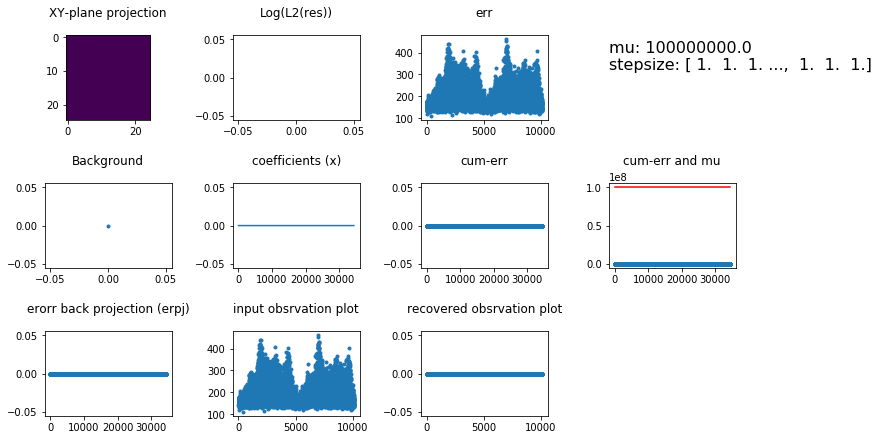

In [58]:
# recover
    # input sensint matrix, and observation; 
    # yield: recovered vector
    # use scikit learn lasso solver
import time
A[:,len(candidate_locs)] = 500
Anorm = A/500
a = LinBreg(Anorm,np.zeros(A.shape[1]),blur.ravel())
a.debug = True
a.deep_debug = True
a.mu = 100000000
#a.stepsize = 1e-6
a.alpha = 1
a.maxit = 1 # maximum iteration steps.
a.debug_it_int = 1
a.it_check_rem = 0 
a.kicking = True
a.getready()
a.go()

In [328]:
A.shape

(10082, 34376)

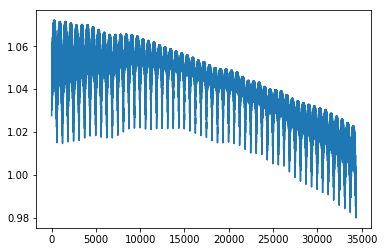

In [329]:
plt.plot(np.mean(Anorm,axis=0))

In [19]:
import numpy as np
l1 = np.arange(1,10) 
l = np.where(l1 != 3 )

In [15]:
l1[l]=100

In [20]:
l

(array([0, 1, 3, 4, 5, 6, 7, 8], dtype=int64),)

In [17]:
l1

array([  1,   2, 100,   4,   5,   6,   7,   8,   9])